In [ ]:
!pip install matplotlib nltk numpy pandas scikit-learn seaborn spacy stop_words

In [ ]:
!python -m spacy download it_core_news_sm

# Data exploration

The data used in this notebook is available [here](https://live.european-language-grid.eu/catalogue/corpus/7498)

In [181]:
import pandas as pd

hs_dev = pd.read_csv("haspeede2_dev_taskAB_anon_revised.tsv")
hs_dev

,id,full_text,hs,stereotype
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0
...,...,...,...,...
6834,9340,Gli stati nazionali devono essere pronti a rin...,0,0
6835,9121,Il ministro dell'interno della Germania #Horst...,0,0
6836,8549,#Salvini: In Italia troppi si sono montati la ...,0,0
6837,9240,@user @user Chi giubila in buona fede non ha c...,0,0


* Get label distributions

HS CLASS DISTRIBUTION 
(raw) 
0    4073
1    2766
Name: hs, dtype: int64 
(%) 
0    0.595555
1    0.404445
Name: hs, dtype: float64

STEREOTYPE CLASS DISTRIBUTION 
(raw) 
0    3797
1    3042
Name: stereotype, dtype: int64 
(%) 
0    0.555198
1    0.444802
Name: stereotype, dtype: float64

CO-OCCURRENCE STATISTICS: 
hs  stereotype
0   0             3049
    1             1024
1   1             2018
    0              748
Name: stereotype, dtype: int64 

AxesSubplot(0.125,0.125;0.775x0.755)


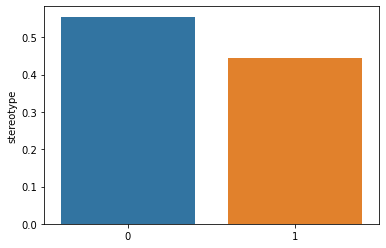

In [182]:
import seaborn as sns

hs_raw = hs_dev.hs.value_counts()
hs_norm = hs_dev.hs.value_counts(normalize=True)
print(f'HS CLASS DISTRIBUTION \n(raw) \n{hs_raw} \n(%) \n{hs_norm}')
ster_raw = hs_dev.stereotype.value_counts()
ster_norm = hs_dev.stereotype.value_counts(normalize=True)
print(f'\nSTEREOTYPE CLASS DISTRIBUTION \n(raw) \n{ster_raw} \n(%) \n{ster_norm}')
hs_ster = hs_dev.groupby('hs')['stereotype'].value_counts()
print(f'\nCO-OCCURRENCE STATISTICS: \n{hs_ster} \n')
#print(sns.barplot(x=hs_norm.index, y=hs_norm))
print(sns.barplot(x=ster_norm.index, y=ster_norm))

* Get most frequent terms and n-grams

In [183]:
import string
from nltk import bigrams, trigrams, FreqDist
from stop_words import get_stop_words

STOPWORDS = get_stop_words('it') + ["url", "user", "@user"]
text = [item for tweet in hs_dev['full_text'] for item in tweet.split(" ") if item.lower() not in STOPWORDS and item not in string.punctuation]
hs_text = [item for tweet in hs_dev[hs_dev.hs == 1]['full_text'] for item in tweet.split(" ") if item.lower() not in STOPWORDS and item not in string.punctuation]
ster_text = [item for tweet in hs_dev[hs_dev.stereotype == 1]['full_text'] for item in tweet.split(" ") if item.lower() not in STOPWORDS and item not in string.punctuation]


"""
#find most common bigrams
bgs = bigrams(ster_text)
fdist = FreqDist(bgs)
fdist.most_common(20)

#find most common trigrams
tgs = trigrams(text)
fdist = FreqDist(tgs)
fdist.most_common(20)
"""
#find most common terms
fdist = FreqDist(text)
fdist.most_common(20)

'\n#find most common bigrams\nbgs = bigrams(ster_text)\nfdist = FreqDist(bgs)\nfdist.most_common(20)\n\n#find most common trigrams\ntgs = trigrams(text)\nfdist = FreqDist(tgs)\nfdist.most_common(20)\n'

# Cleaning and preprocessing

* tokenization
* stopwords+punctuation removal
* lowercasing
* lemmatization
* ... and many other stuff

In [184]:
import re, spacy, string
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


def preprocess(sentence):
    #remove digits
    text = re.sub('\d+', '', sentence)
    #remove extra whitespaces
    text = re.sub('\s+', ' ', text)
    #tokenization
    text = word_tokenize(text)
    #stopwords/punctuation removal + lowercasing
    text = [token.lower() for token in text if token.lower() not in STOPWORDS and token not in string.punctuation]
    #lemmatization
    #sent = " ".join(text)
    #nlp = spacy.load("it_core_news_sm")
    #text = [token.lemma_ for token in nlp(sent)]
    #stemming
    stemmer = SnowballStemmer('italian')
    text = [stemmer.stem(token) for token in text]
    #other possible operations: handle emojis/emoticons, hashtags, URLs/email addresses, twitter handles 
    return " ".join(text) 
 

hs_dev['preprocessed'] = hs_dev['full_text'].apply(lambda x: preprocess(x))
hs_dev

,id,full_text,hs,stereotype,preprocessed
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0,terror mett stat soggezion person rend innocu ...
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0,infatt finc guadagn camp rom ok alemann ipocr
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0,corr tangent maf capital dimenticatamazzett bu...
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0,quand migrant israel arriv terr canaan fuor ca...
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0,divert giorn trov patriot italian innegg rom s...
...,...,...,...,...,...
6834,9340,Gli stati nazionali devono essere pronti a rin...,0,0,stat nazional dev esser pront rinunc propr sov...
6835,9121,Il ministro dell'interno della Germania #Horst...,0,0,ministr dell'intern german horstseehofer propo...
6836,8549,#Salvini: In Italia troppi si sono montati la ...,0,0,salvin ital tropp mont test ringraz dio mes st...
6837,9240,@user @user Chi giubila in buona fede non ha c...,0,0,giubil buon fed cap nient purtropp cred buon f...


# Train-Test/Validation split
(In this case we already have a held-out test set, but you might want to use a validation set as well for hyper-parameter tuning)


In [185]:
from sklearn.model_selection import train_test_split

#if you split into train and validation sets:
X_train_hs, X_val_hs, y_train_hs, y_val_hs = train_test_split(hs_dev["preprocessed"],hs_dev["hs"],test_size=0.1)

#if you just use the whole training set without hyper-parameter tuning:
X_train_hs = hs_dev["preprocessed"]
y_train_hs = hs_dev["hs"]

X_train_hs



0       terror mett stat soggezion person rend innocu ...
1           infatt finc guadagn camp rom ok alemann ipocr
2       corr tangent maf capital dimenticatamazzett bu...
3       quand migrant israel arriv terr canaan fuor ca...
4       divert giorn trov patriot italian innegg rom s...
                              ...                        
6834    stat nazional dev esser pront rinunc propr sov...
6835    ministr dell'intern german horstseehofer propo...
6836    salvin ital tropp mont test ringraz dio mes st...
6837    giubil buon fed cap nient purtropp cred buon f...
6838    giovan cristian etiop indott islam convert all...
Name: preprocessed, Length: 6839, dtype: object

# Feature extraction and modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

#"""
#create feature vectors
count = CountVectorizer(analyzer='word', max_features=5000)
count_train = count.fit_transform(X_train_hs)
tfidf = TfidfVectorizer(analyzer='word', max_features=5000)
tfidf_train = tfidf.fit_transform(X_train_hs)
trg = TfidfVectorizer(analyzer='word', ngram_range= (1,3), max_features=5000)
trg_train = trg.fit_transform(X_train_hs)

#fit the classifier on the training data
svm = LinearSVC() # as classifier, we just use a linear SVM with default parameters
svm_tfidf = LinearSVC()
svm_trg = LinearSVC()
svm.fit(count_train, y_train_hs)
svm_tfidf.fit(tfidf_train, y_train_hs)
svm_trg.fit(trg_train, y_train_hs)
#"""

""" alternative code using make_pipeline:
count = CountVectorizer(analyzer='word', max_features=5000)
tfidf = TfidfVectorizer(analyzer='word', max_features=5000)
tfidf_trg = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features=5000)

svm = LinearSVC()  
svm_tfidf = LinearSVC()
svm_trg = LinearSVC()

pipe_count = make_pipeline(count, svm)
pipe_tfidf = make_pipeline(tfidf, svm_tfidf)
pipe_trigrams = make_pipeline(tfidf_trg, svm_trg)

pipe_count.fit(X_train_hs, y_train_hs)
pipe_tfidf.fit(X_train_hs, y_train_hs)
pipe_trigrams.fit(X_train_hs, y_train_hs)
"""

# Evaluation and error analysis

In [187]:
from sklearn.metrics import classification_report, confusion_matrix

hs_test = pd.read_csv("haspeede2_reference_taskAB-tweets_anon_revised.tsv")
#hs_test = pd.read_csv("haspeede2_reference_taskAB-news_anon_revised.tsv")
hs_test

X_test_hs = hs_test['full_text'].apply(lambda x: preprocess(x))
y_test_hs = hs_test['hs']

#"""
count_test = count.transform(X_test_hs)
tfidf_test = tfidf.transform(X_test_hs)
trg_test = trg.transform(X_test_hs)

y_pred_count = svm.predict(count_test)
y_pred_tfidf = svm_tfidf.predict(tfidf_test)
y_pred_trg = svm_trg.predict(trg_test)
#"""
"""
y_pred_count = pipe_count.predict(X_test_hs)
y_pred_tfidf = pipe_tfidf.predict(X_test_hs)
y_pred_trg = pipe_trigrams.predict(X_test_hs)
"""

print('COUNT VECTORS: \n\nCONFUSION MATRIX ')       
print(confusion_matrix(y_test_hs, y_pred_count), '\n') 
print('EVALUATION METRICS \n',classification_report(y_test_hs, y_pred_count))
print('TF-IDF VECTORS: \n\nCONFUSION MATRIX ')       
print(confusion_matrix(y_test_hs, y_pred_tfidf), '\n') 
print('EVALUATION METRICS \n',classification_report(y_test_hs, y_pred_tfidf))
print('TF-IDF VECTORS + TRIGRAMS: \n\nCONFUSION MATRIX ')  
print(confusion_matrix(y_test_hs, y_pred_trg), '\n') 
print('EVALUATION METRICS \n',classification_report(y_test_hs, y_pred_trg))


COUNT VECTORS: 

CONFUSION MATRIX 
[[452 189]
 [177 445]] 

EVALUATION METRICS 
               precision    recall  f1-score   support

           0       0.72      0.71      0.71       641
           1       0.70      0.72      0.71       622

    accuracy                           0.71      1263
   macro avg       0.71      0.71      0.71      1263
weighted avg       0.71      0.71      0.71      1263

TF-IDF VECTORS: 

CONFUSION MATRIX 
[[478 163]
 [153 469]] 

EVALUATION METRICS 
               precision    recall  f1-score   support

           0       0.76      0.75      0.75       641
           1       0.74      0.75      0.75       622

    accuracy                           0.75      1263
   macro avg       0.75      0.75      0.75      1263
weighted avg       0.75      0.75      0.75      1263

TF-IDF VECTORS + TRIGRAMS: 

CONFUSION MATRIX 
[[448 193]
 [160 462]] 

EVALUATION METRICS 
               precision    recall  f1-score   support

           0       0.74      0.70  

Try using visual libraries to explain system's predictions, like [eli5](https://github.com/TeamHG-Memex/eli5) or 
[LIME](https://marcotcr.github.io/lime/). Both packages provide nice tutorials. Here an example using eli5 (source available [here](https://github.com/TeamHG-Memex/eli5/blob/master/notebooks/Debugging%20scikit-learn%20text%20classification%20pipeline.ipynb))

In [188]:
import eli5

eli5.show_weights(svm_tfidf, vec=tfidf, top=10)

C:\Users\manzu\miniconda3\envs\jun2022\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Try using the best-performing model with some brand new data

In [189]:
sent = [preprocess("stranieri tutti a casa")] #put here some made-up sentence, just to see how the model goes
new = tfidf.transform(sent)
y_pred_tfidf = svm_tfidf.predict(new)
print(sent, y_pred_tfidf)


['stranier cas'] [1]


To perform <b>error analysis</b>:
* select a sample of mislabeled data
* compare results with gold annotation
* get insights on possible causes of misclassification (also defining patterns, if any)